# Chapter 9: Linear Regression

本章运用之前章节的数学概念来解决线性回归问题（曲线拟合问题）。 

要解决线性回归问题需要解决以下问题：
* 模型类别的选择以及参数化
    * 什么函数类型比较好？
    * 多项式的次数定到多少比较好？
* 找到好参数：
    * 定义目标函数
    * 定义优化算法
* 过拟合以及模型选择（model selection）
* 损失函数和参数先验概率的关系
* 对不确定性的建模（uncertainty modeling）

**本章主要内容**：
* 用 MLE， MAP estimate 预测线性回归中的模型参数
* 如何解决线性回归中的过拟合问题？
* 贝叶斯线性回归 (Bayesian Linear Regression)

## 9.1 Problem Formulation 

线性回归问题是： 给定一些数据， 以及其对应的函数值（有噪声）， 我们想要找到一个能够很好地表示数据和对应函数值之间的关系的函数。 

用数学语言描述如下：

$$p(y \mid x) = \mathcal{N}(y \mid f(x), \sigma^2)$$

其中 $x\in\mathbb{R}^D$ 是输入数据， $y\in \mathbb{R}$ 是 noised 的函数值（target value）。$x$ 和 $y$ 之间的关系可以表示如下：

$$y = f(x) + \epsilon$$

其中 $\epsilon \sim \mathcal{N}(0, \sigma^2)$ 是独立同分布的高斯噪声， 函数 $f(\cdot)$ 是未知的。

我们的目标：**找到一个模型， 它能够很好地拟合函数 $f(\cdot)$ 已经生成的数据（all labeled data）, 并且能够泛化地很好（在 `unseen data` 上也有很好表现）**

注：
* 噪声模型可以有多种选择， 本章默认噪声服从均值为0方差为 $\sigma^2$的高斯分布： $\epsilon \sim \mathcal{N}(0, \sigma^2)$
* 为了把我们的工作重心放在对模型参数的学习上， 暂时假设 $\sigma$ 是已知的

假设我们的模型以 $\theta$ 为参数， 线性回归的例子可以表示如下：

$$
\begin{array}{r}
p(y \mid \boldsymbol{x}, \boldsymbol{\theta})=\mathcal{N}\left(y \mid \boldsymbol{x}^{\top} \boldsymbol{\theta}, \sigma^{2}\right) \\
\Longleftrightarrow y=\boldsymbol{x}^{\top} \boldsymbol{\theta}+\epsilon, \quad \epsilon \sim \mathcal{N}\left(0, \sigma^{2}\right)
\end{array}
$$

其中 $\theta \in \mathbb{R}^D$。 上式中的似然函数表示的是 $y$ 在 $x^T\theta$ 处的概率密度函数。 如果没有 `observation noise`， 也就是说如果 $\sigma=0$， $x$ 和 $y$ 的关系就不再是随机的了， 而是确定的（也是个 Dirac delta）

注：
* Dirac delta 函数： 除了一个点外， 其他所有点处都为0， 它的积分为1

$y=\boldsymbol{x}^{\top} \boldsymbol{\theta}$中， 不仅参数是线性的， 输入数据 $x$ 也是线性的。 我们也可以对 $x$ 用非线性变换： $y=\phi^{\top}(\boldsymbol{x}) \boldsymbol{\theta}$， 这也叫做线性代数。 因为线性代数只要求模型 `linear in parameters`: 即能表示输入特征的线性组合。我们可以把 $\phi^{\top}(\boldsymbol{x})$ 当作输入特征。 

注：
* $y=\boldsymbol{x}^{\top} \boldsymbol{\theta}$ 是 $y=\phi^{\top}(\boldsymbol{x}) \boldsymbol{\theta}$ 的一种特殊形式。

## 9.2 Parameter Estimation

假设我们有训练集 $\mathcal{D} = {(x_1, y_1), ..., (x_N, y_N)}$ 包含 $N$ 个输入数据 $x_n\in \mathbb{R}^D$ 和与之对应的观测值 $y_n\in \mathbb{R}, n=1, ..., N$。 因为在分别给定 $x_i, x_j$的情况下， $y_i, y_j$ 条件独立， 所以我们可以把似然函数做如下因式分解：

$$
\begin{aligned}
p(\mathcal{Y} \mid \mathcal{X}, \theta) &=p\left(y_{1}, \ldots, y_{N} \mid x_{1}, \ldots, x_{N}, \theta\right) \\
&=\prod_{n=1}^{N} p\left(y_{n} \mid x_{n}, \theta\right)=\prod_{n=1}^{N} \mathcal{N}\left(y_{n} \mid x_{n}^{\top} \theta, \sigma^{2}\right)
\end{aligned}
$$

其中 $\mathcal{X} = \{x_1, ..., x_N \}, \mathcal{Y} = \{y_1, ..., y_N\}$, 因为噪声服从高斯分布的原因， $ p\left(y_{n} \mid x_{n}, \theta\right)$ 也服从高斯分布。 

接下来的主要任务就是怎样找到最优参数 $\theta^*$ 了。 如果参数 $\theta^*$ 被确定的话， 我们就可以通过下面的式子预测测试集中任意输入数据 $x_*$ 所对应的目标值了：

$$
p\left(y_{*} \mid x_{*}, \theta^{*}\right)=\mathcal{N}\left(y_{*} \mid x_{*}^{\top} \theta^{*}, \sigma^{2}\right)
$$

### 9.2.1 Maximum Likelihood Estimation

前面我们已经介绍了最大似然估计： 找到能够最大化似然函数的参数 $\theta_{ML}$。 

$$\theta_{ML} = \arg \max_{\theta}p(\mathcal{Y} \mid \mathcal{X}, \theta)$$

似然函数最大(参数已经确定)意味着：在给定 $\mathcal{X}$ 的情况下，观测到 $\mathcal{Y}$ 的可能性最大

怎么最大化似然函数呢？

* 用梯度上升法 （或对 negative log likelihood 用梯度下降法）
* 直接 `analytically` 求解

这里我们先把似然函数化为 negative log likelihood（目标转换为最小化）， 然后 `analytically` 求解。 

似然函数的 negative log likelihood 形式为：

$$
\begin{aligned}
-\log p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})  &= -\log \prod_{n=1}^{N} p\left(y_{n} \mid \boldsymbol{x}_{n}, \boldsymbol{\theta}\right) \\  &= -\sum_{n=1}^{N} \log p\left(y_{n} \mid \boldsymbol{x}_{n}, \boldsymbol{\theta}\right) \\
&= \frac{1}{2 \sigma^{2}} \sum_{n=1}^{N}\left(y_{n}-x_{n}^{\top} \theta\right)^{2}- \underbrace{\sum_{n=1}^{N} \log \frac{1}{\sqrt{2 \pi \sigma^{2}}}}_\text{constant} 
\end{aligned}
$$

忽略常数项， 可得：

$$
\begin{aligned}
\mathcal{L}(\theta) &:=\frac{1}{2 \sigma^{2}} \sum_{n=1}^{N}\left(y_{n}-x_{n}^{\top} \theta\right)^{2} \\
&=\frac{1}{2 \sigma^{2}}(y-X \theta)^{\top}(y-X \theta)=\frac{1}{2 \sigma^{2}}\|y-X \theta\|^{2}
\end{aligned}
$$

其中我们把 $X = [x_1, ..., x_N]^{\top}\in R^{N\times D}$ 成为 `design matrix`, $y=[y_1, ..., y_N]^{\top}\in \mathbb{R}^N$ 是对应的观测值（label）。 design matarix 第 $n$ 行对应着输入数据 $x_n$。 

对 $\mathcal{L}$ 关于 $\theta$ 求导有：

$$
\begin{aligned}
\frac{\mathrm{d} \mathcal{L}}{\mathrm{d} \theta} &=\frac{\mathrm{d}}{\mathrm{d} \theta}\left(\frac{1}{2 \sigma^{2}}(y-X \boldsymbol{\theta})^{\top}(y-X \boldsymbol{\theta})\right) \\
&=\frac{1}{2 \sigma^{2}} \frac{\mathrm{d}}{\mathrm{d} \theta}\left(y^{\top} \boldsymbol{y}-2 y^{\top}  X\boldsymbol{\theta}+\boldsymbol{\theta}^{\top} X^{\top} X \boldsymbol{\theta}\right) \\
&=\frac{1}{\sigma^{2}}\left(-y^{\top}  X+\boldsymbol{\theta}^{\top} X^{\top}  X\right) \in \mathbb{R}^{1 \times D}
\end{aligned}
$$

令导数为零， 可得：

$$
\begin{aligned}
\frac{\mathrm{d} \mathcal{L}}{\mathrm{d} \theta}=\mathbf{0}^{\top} & \Longleftrightarrow \theta_{\mathrm{ML}}^{\top} X^{\top} X=y^{\top} X \\
& \Longleftrightarrow \theta_{\mathrm{ML}}^{\top}=y^{\top} X\left(X^{\top} X\right)^{-1} \\
& \Longleftrightarrow \theta_{\mathrm{ML}}=\left(X^{\top} X\right)^{-1} X^{\top} y
\end{aligned}
$$

注：
* 因为 `Hessian` $\nabla_{\theta}^2 = X^{\top}X \in \mathbb{R}^{D\times D}$ 是正定的， 所以我们求得的 $\theta_{ML}$ 就是 $\mathcal{L}$ 的最小值点
* $\theta_{\mathrm{ML}}^{\top} X^{\top} X=y^{\top} X$ 其实是解了一个线性方程组 $A\theta = b$, 其中 $A=(X^{\top}X), b=X^{\top}y$
* 因为要保证 $X^{\top} X \in \mathbb{R}^{D \times D}$ 可逆， 所以 $\mathrm{rk}(X)=D$

#### Maximum Likelihood Estimation with Features

前面提到过， 我们现在考虑的线性回归 $y=\boldsymbol{x}^{\top} \boldsymbol{\theta}$ 是 $y=\phi^{\top}(\boldsymbol{x}) \boldsymbol{\theta}$ 的一种特殊形式。现在的模型 $y=\boldsymbol{x}^{\top} \boldsymbol{\theta}$ 只能拟合直线， 但是对 $x$ 做非线性变换化为 $\phi(x)$， 然后对 $\phi(x)$ 进行线性组合， 即：$y=\phi^{\top}(\boldsymbol{x}) \boldsymbol{\theta}$， 这样我们就可以拟合非线性函数了。 数学语言如下：

$$
\begin{array}{r}
p(y \mid x, \theta)=\mathcal{N}\left(y \mid \phi^{\top}(x) \theta, \sigma^{2}\right) \\
\Longleftrightarrow y=\phi^{\top}(x) \theta+\epsilon=\sum_{k=0}^{K-1} \theta_{k} \phi_{k}(x)+\epsilon
\end{array}
$$

其中 $\phi: \mathbb{R}^D \rightarrow \mathbb{R}^K$ 是对输入 $x$ 的非线性转换， $\phi_k: \mathbb{R}^D \rightarrow \mathbb{R}$ 是 特征向量 $\phi$ 的 第 $k$ 个元素。 

假设训练集的数据 $x_n\in \mathbb{R}^D, y_n\in \mathbb{R}, n=1, ..., N$, 那么 design matrix(又叫 feature matrix) 可以定义如下：

$$
\Phi:=\left[\begin{array}{c}
\phi^{\top}\left(x_{1}\right) \\
\vdots \\
\phi^{\top}\left(x_{N}\right)
\end{array}\right]=\left[\begin{array}{ccc}
\phi_{0}\left(x_{1}\right) & \cdots & \phi_{K-1}\left(x_{1}\right) \\
\phi_{0}\left(x_{2}\right) & \cdots & \phi_{K-1}\left(x_{2}\right) \\
\vdots & & \vdots \\
\phi_{0}\left(x_{N}\right) & \cdots & \phi_{K-1}\left(x_{N}\right)
\end{array}\right] \in \mathbb{R}^{N \times K}
$$

其中 $\Phi_{ij} = \phi_j(x_i), \phi_j: \mathbb{R}^D \rightarrow \mathbb{R}$

在这种情况下， negative log-likelihood 可以写做如下：

$$
-\log p(\mathcal{Y} \mid \mathcal{X}, \theta)=\frac{1}{2 \sigma^{2}}(y-\Phi \theta)^{\top}(y-\Phi \theta)+\text { const }
$$

像之前一样， 对 $\theta$ 求导， 令导数为零， 可以求得 $\theta_{ML}$:

$$
\theta_{\mathrm{ML}}=\left(\Phi^{\top} \Phi\right)^{-1} \Phi^{\top} y
$$

注：
* 其实只是把之前 $\theta_{\mathrm{ML}}=\left(X^{\top} X\right)^{-1} X^{\top} y$ 中的 $X$ 换成了 $\Phi$
* 同样地， 因为要保证 $\Phi^{\top} \Phi \in \mathbb{R}^{K\times K}$ 可逆 $\Longleftrightarrow \mathrm{rk}(\Phi) = K$ 

#### Estimating the Noise Variance

我们之前默认噪声方差 $\sigma^2$ 是已知的， 其实如果它是未知的，我们也可以用最大似然估计的方法来估计 $\sigma^2_\mathrm{ML}$。 
同样的步骤：

1. 写出 log-likelihood：

$$
\begin{array}{l}
\log p\left(\mathcal{Y} \mid \mathcal{X}, \theta, \sigma^{2}\right)=\sum_{n=1}^{N} \log \mathcal{N}\left(y_{n} \mid \phi^{\top}\left(x_{n}\right) \theta, \sigma^{2}\right) \\
\quad=\sum_{n=1}^{N}\left(-\frac{1}{2} \log (2 \pi)-\frac{1}{2} \log \sigma^{2}-\frac{1}{2 \sigma^{2}}\left(y_{n}-\phi^{\top}\left(x_{n}\right) \theta\right)^{2}\right) \\
\quad=-\frac{N}{2} \log \sigma^{2}-\frac{1}{2 \sigma^{2}} \underbrace{\sum_{n=1}^{N}\left(y_{n}-\phi^{\top}\left(x_{n}\right) \theta\right)^{2}}_{=: s}+\text { const }
\end{array}
$$

2. 对 $\sigma^2$ 求导， 令导数为0：

$$
\begin{aligned}
& \frac{\partial \log p\left(\mathcal{Y} \mid \mathcal{X}, \theta, \sigma^{2}\right)}{\partial \sigma^{2}}=-\frac{N}{2 \sigma^{2}}+\frac{1}{2 \sigma^{4}} s=0 \\
\Longleftrightarrow & \frac{N}{2 \sigma^{2}}=\frac{s}{2 \sigma^{4}}
\end{aligned}
$$

最后我们可以得到：

$$
\sigma_{\mathrm{ML}}^{2}=\frac{s}{N}=\frac{1}{N} \sum_{n=1}^{N}\left(y_{n}-\phi^{\top}\left(x_{n}\right) \theta\right)^{2}
$$


可以看出 $\sigma_{\mathrm{ML}}^{2}$ 就是 noise-free 函数值 $\phi^{\top}\left(x_{n}\right) \theta$ 和 其对应的 noisy 观测值 $y_n$ 的 实际均方距离 （empirical mean of squared distance）


### 9.2.2 Overfitting in Linear Regression

我们已经讨论了如何得到 $\theta_\mathrm{ML}^2$， 为了评估模型的性能， 我们可以计算模型在测试集上的误差（损失）。 常用的损失函数就是之前的 negative log-likelihood 函数（忽略常数项后）：

$$\mathcal{L}(\theta)= \frac{1}{2 \sigma^{2}} \|y-\Phi \theta\|^{2}$$

假设 $\sigma^2$ 是固定不变的， 那么我们可以把上述损失函数写成： 

$$\mathcal{L}(\theta) = \|y-\Phi \theta\|^{2}$$

但是通常我们会在上式的基础上加平方根， 得到 `root mean square error`:

$$\mathcal{L}(\theta) = \sqrt{\frac{1}{N}\|y-\Phi \theta\|^{2}}=\sqrt{\frac{1}{N} \sum_{n=1}^{N}\left(y_{n}-\phi^{\top}\left(x_{n}\right) \theta\right)^{2}}$$

我们可以根据模型在测试集上的损失大小来进行 model selection。 

比如书中讨论了多项式次数选择的问题： 

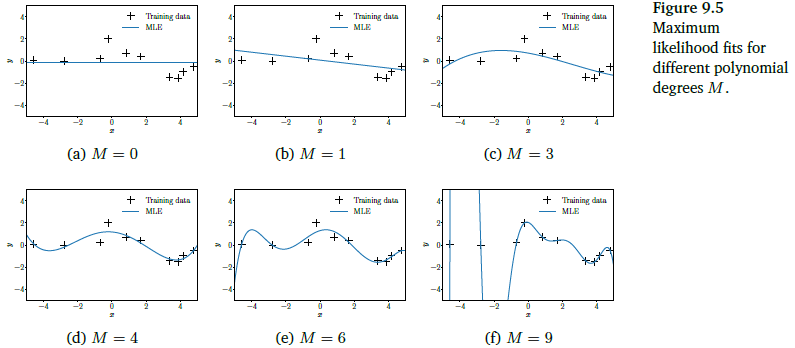

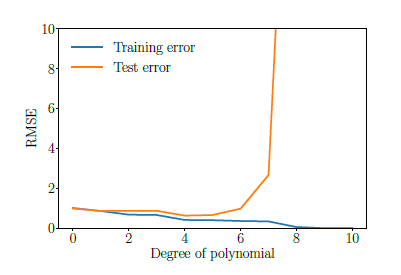

当多项式次数 $M$ 增大时， 我们的模型越来越复杂， 对训练数据的拟合也越来越好但是在训练集上的损失却在 $M = 4$ 以后迅速增加， 出现了过拟合现象。 

注：
* 这里多项式次数指的是我们构建 design matrix 时最高考虑到 $x_n\in \mathbb{R}, n=1, ..., N$ 的多少次幂。 比如考虑到2次时可以得到：
$$
\Phi=\left[\begin{array}{ccc}
1 & x_{1} & x_{1}^{2} \\
1 & x_{2} & x_{2}^{2} \\
\vdots & \vdots & \vdots \\
1 & x_{N} & x_{N}^{2}
\end{array}\right]
$$

* 因为我们在求解 $\theta_\mathrm{ML}$ 时， 需要解线性方程 $A\theta = b$, 其中 $A=(\Phi^{\top}\Phi), b=\Phi^{\top}y$， 如果我们考虑的最高次数 $M \ge N$， 那么 $A=(\Phi^{\top}\Phi)$ 就不可逆了，解线性方程 $A\theta = b$ 会有无数可解， 也就是说我们的 $\theta_\mathrm{ML}$ 就不唯一了。 

### 9.2.3 Maximum A Posteriori Estimation

上一子节我们探讨了怎么运用 MLE 来解决 线性回归问题， 但是我们在上一子节的最后我们也可以看到使用 MLE 容易出现过拟合问题。 本章采用 MAP estimate 的方法来解决线性回归问题， 与之前的 MLE 相比， MAP estimate 能一定程度上减轻过拟合问题。 

先说下为什么用 MAP estimate 能一定程度上减轻过拟合问题（个人理解）：通常当发生过拟合问题时， 模型的参数都会比较大。 所以我们可以引入参数 $\theta$ 的先验概率, 比如： $p(\theta) = \mathcal{N}(0, 1)$， 意味着我们在训练开始前认为 $\theta$ 很可能在 $[-2, 2]$ 之间（均值两个标准差范围）。然后我们在优化时在原有的似然函数的基础上乘以先验概率 $p(\theta)$， 这样发生过拟合模型的参数变大时， 对 $\theta$ 的 prior knowledge 会起到一个 "缓冲" 作用！ (从下面 log-posterior 式子中也可以看出)

前面也已经提到， 与 MLE 不同的是， MAP estimate 中我们想要最大化的是后验概率:

$$
p(\theta \mid \mathcal{X}, \mathcal{Y})=\frac{p(\mathcal{Y} \mid \mathcal{X}, \theta) p(\theta)}{p(\mathcal{Y} \mid \mathcal{X})}
$$

化为 log-posterior 形式：

$$
\log p(\theta \mid \mathcal{X}, \mathcal{Y})=\log p(\mathcal{Y} \mid \mathcal{X}, \theta)+\log p(\theta)+\text { const }
$$

我们的目标就是最小化 negative log-posterior:

$$
\theta_{\mathrm{MAP}} \in \arg \min _{\theta}\{-\log p(\mathcal{Y} \mid \mathcal{X}, \theta)-\log p(\theta)\}
$$


求 negative log-posterior 对 $\theta$ 的导数：

$$
-\frac{\mathrm{d} \log p(\theta \mid \mathcal{X}, \mathcal{Y})}{\mathrm{d} \theta}=-\frac{\mathrm{d} \log p(\mathcal{Y} \mid \mathcal{X}, \theta)}{\mathrm{d} \theta}-\frac{\mathrm{d} \log p(\theta)}{\mathrm{d} \theta}
$$

假设 $p(\theta) = \mathcal{N}(0, b^2I)$, 可得 negative log-posterior 为：

$$
-\log p(\theta \mid \mathcal{X}, \mathcal{Y})=\frac{1}{2 \sigma^{2}}(y-\Phi \theta)^{\top}(y-\Phi \theta)+\frac{1}{2 b^{2}} \theta^{\top} \theta+\mathrm{const}
$$

negative log-posterior 对 $\theta$ 的导数为：

$$
-\frac{\mathrm{d} \log p(\theta \mid \mathcal{X}, \mathcal{Y})}{\mathrm{d} \theta}=\frac{1}{\sigma^{2}}\left(\theta^{\top} \Phi^{\top} \Phi-y^{\top} \Phi\right)+\frac{1}{b^{2}} \theta^{\top}
$$

令导数为0， 可得 $\theta_\mathrm{MAP}$ 如下：

$$
\begin{aligned}
& \frac{1}{\sigma^{2}}\left(\theta^{\top} \Phi^{\top} \Phi-y^{\top} \Phi\right)+\frac{1}{b^{2}} \theta^{\top}=0^{\top} \\
\Longleftrightarrow & \theta^{\top}\left(\frac{1}{\sigma^{2}} \Phi^{\top} \Phi+\frac{1}{b^{2}} I\right)-\frac{1}{\sigma^{2}} y^{\top} \Phi=0^{\top} \\
\Longleftrightarrow & \theta^{\top}\left(\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I\right)=y^{\top} \Phi \\
\Longleftrightarrow & \theta^{\top}=y^{\top} \Phi\left(\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I\right)^{-1}\\
\Longleftrightarrow & \theta_{\mathrm{MAP}}=\left(\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I\right)^{-1} \Phi^{\top} y
\end{aligned}
$$

可以看出 $\theta_{\mathrm{MAP}}=\left(\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I\right)^{-1} \Phi^{\top} y$ 与 $\theta_{\mathrm{ML}}=\left(\Phi^{\top} \Phi\right)^{-1} \Phi^{\top} y$ 差别在于多了 $\frac{\sigma^2}{b^2}I$ 这一项。 也正是这一项，保证了 $\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I$ 是对称正定的， 且缓和了 overfitting 问题， 发挥了 regularizer 的作用。 

### 9.2.4 MAP Estimation as Regularization

除了上子节中利用 $\theta$ 先验概率的方法， 我们也可以在原有目标函数的基础上引入惩罚项:

$$
\min_{\theta}\{\|y-\Phi \theta\|^{2}+\lambda\|\theta\|_{2}^{2}\}
$$

可以从两个角度来理解这么做的原因（个人理解）：
1. 发生 overfitting 时 参数 $\theta$ 通常变得很大， 所以我们引入惩罚项来防止 $\theta$ 变太大。
2. overfitting 发生时意味着在训练集上的损失低估了真正的损失， 所以我们在损失函数上加上惩罚项， 以减少对真正损失的低估。 加入的惩罚项必须跟 $\theta$ 有关， 否则加了也是常数可以忽略。  

注：
* 在上面的式子中我们的惩罚项使用了欧几里得范数， 我们也可以用其他范数。 

Regularizer $\lambda\|\theta\|_{2}^{2}$ 也可以用上面的 negative log-Gaussian prior 解释。 

negative log-posterior 如下：

$$
-\log p(\theta \mid \mathcal{X}, \mathcal{Y})=\frac{1}{2 \sigma^{2}}(y-\Phi \theta)^{\top}(y-\Phi \theta)+ \underbrace{\frac{1}{2 b^{2}} \theta^{\top} \theta+\mathrm{const}}_{-\log p(\theta)}
$$

忽略 $\frac{1}{2 \sigma^{2}}$， 比较上式和引入惩罚项的目标函数， 我们可以看出当 $\lambda = \frac{1}{2b^{2}}$ 时两式子相等。 

同样地， 我们对 $\|y-\Phi \theta\|^{2}+\lambda\|\theta\|_{2}^{2}\$ 求导， 令导数为零， 可得：

$$
\theta_{\mathrm{RIS}}=\left(\Phi^{\top} \Phi+\lambda I\right)^{-1} \Phi^{\top} y
$$

可以看出跟之前的 $\theta_{\mathrm{MAP}}=\left(\Phi^{\top} \Phi+\frac{\sigma^{2}}{b^{2}} I\right)^{-1} \Phi^{\top} y$ 很相似， 当 $\lambda = \frac{\sigma^2}{b^2}$ 时， $\theta_{\mathrm{RIS}} = \theta_{\mathrm{MAP}}$

## 9.3 Bayesian Linear Regression

前面的 MLE 方法和 MAP estimate 方法属于 point estimate 方法， 得到的只是单个参数。 贝叶斯线性回归不再对单个参数做估计， 而是在预测时考虑到参数的整个后验概率分布。 也就是说， 我们不再拟合任何参数， 而是根据参数的后验概率求所有可能参数的平均。 

### 9.3.1 Model

我们考虑的模型如下：

$$
\begin{aligned}
\text { prior： }&p(\theta)=\mathcal{N}\left(m_{0}, \boldsymbol{S}_{0}\right)\\
\text { likelihood： } &p(y \mid x, \theta)=\mathcal{N}\left(y \mid \phi^{\top}(x) \theta, \sigma^{2}\right)
\end{aligned}
$$

$y$ 和 $\theta$ 的联合分布如下：

$$
p(y, \theta \mid x)=p(y \mid x, \theta) p(\theta)
$$

### 9.3.2 Prior Predictions

本子节介绍怎么通过先验概率进行预测 (prior predictions)。 

前面我们一直在讨论怎么求得模型的好参数， 其实在实际中， 我们通常注重借助得到的模型参数来做预测。在贝叶斯设定下， 我们借助参数的分布并求所有可能参数下的预测值的平均。 具体来说的话， 给定输入数据 $x_*$， 我们对 $\theta$ 积分， 可以得到下面的式子：

$$
p\left(y_{*} \mid x_{*}\right)=\int p\left(y_{*} \mid x_{*}, \theta\right) p(\theta) \mathrm{d} \theta=\mathbb{E}_{\theta}\left[p\left(y_{*} \mid x_{*}, \theta\right)\right]
$$

对上式解释下就是： 根据 $p(\theta)$， 我们对所有可能的参数 $\theta$ 下的预测值 $y_* \mid x_*, \theta$ 求了平均。 

我们已经假设 $\theta$ 的先验概率是高斯分布 $p(\theta)=\mathcal{N}\left(m_{0}, \boldsymbol{S}_{0}\right)$， 那么 predictive distribution 也是如下的高斯分布：

$$
p\left(y_{*} \mid \boldsymbol{x}_{*}\right)=\mathcal{N}\left(\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{m}_{0}, \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{0} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)+\sigma^{2}\right)
$$

其中 $\boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \boldsymbol{S}_{0} \boldsymbol{\phi}\left(\boldsymbol{x}_{*}\right)$ 表示的是对 $\theta$ 的不确定性， $\sigma^2$ 表示的是 measurement noise 的不确定性。 

如果 target value 是没有误差的， 也就是说 $y_* = \boldsymbol{\phi}^{\top}\left(\boldsymbol{x}_{*}\right) \theta$, 那么这种情况下的 predictive distribution 为：

$$
p\left(f\left(x_{*}\right)\right)=\mathcal{N}\left(\phi^{\top}\left(x_{*}\right) m_{0}, \phi^{\top}\left(x_{*}\right) S_{0} \phi\left(x_{*}\right)\right)
$$

跟之前的 predictive distribution 的不同就在于 noise variance $\sigma^2$

### 9.3.3 Posterior Distribution

比起用先验概率做预测， 用后验概率做预测会更加准确。 所以接下来我们讨论如何用后验概率做预测， 但是首先我们讨论如何得到后验概率 $p(\theta \mid \mathcal{X}, \mathcal{Y})$。 

根据贝叶斯定理， $\theta$ 的后验概率如下：

$$
p(\theta \mid \mathcal{X}, \mathcal{Y})=\frac{p(\mathcal{Y} \mid \mathcal{X}, \theta) p(\theta)}{p(\mathcal{Y} \mid \mathcal{X})}
$$

其中， $\mathcal{X}$ 是训练输入， \mathcal{Y} 是对应的 training targets, $p(\mathcal{Y} \mid \mathcal{X}, \theta)$ 是似然函数， p(\theta)是先验概率。$ p(\mathcal{Y} \mid \mathcal{X})$ 是 `marginal likelihood` 又叫 `evidence`, 计算方式如下：

$$
p(\mathcal{Y} \mid \mathcal{X})=\int p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta}) p(\boldsymbol{\theta}) \mathrm{d} \boldsymbol{\theta}=\mathbb{E}_{\boldsymbol{\theta}}[p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})]
$$

因为先验概率是高斯分布， 根据共轭性质， 后验概率 $p(\theta \mid \mathcal{X}, \mathcal{Y})$ 也应该是高斯分布。 

我们可得：
$$
\begin{aligned}
&p(\theta \mid \mathcal{X}, \mathcal{Y})=\exp (\log p(\theta \mid \mathcal{X}, \mathcal{Y})) \propto \exp (\log p(\mathcal{Y} \mid \mathcal{X}, \theta)+\log p(\theta))\\
&\propto \exp \left(-\frac{1}{2}\left(\theta^{\top}\left(\sigma^{-2} \Phi^{\top} \Phi+S_{0}^{-1}\right) \theta-2\left(\sigma^{-2} \Phi^{\top} y+S_{0}^{-1} m_{0}\right)^{\top} \theta + \mathrm{const}\right)\right)
\end{aligned}
$$

假设后验概率 $p(\theta \mid \mathcal{X}, \mathcal{Y}) \sim \mathcal{N}(\theta \mid, m_N, S_N)$

则我们有：

$$
\begin{aligned}
S_{N}^{-1} &=\Phi^{\top} \sigma^{-2} I \Phi+S_{0}^{-1} \\
\Longleftrightarrow & S_{N}=\left(\sigma^{-2} \Phi^{\top} \Phi+S_{0}^{-1}\right)^{-1}
\end{aligned}
$$

$$
\begin{array}{r}
m_{N}^{\top} S_{N}^{-1}=\left(\sigma^{-2} \Phi^{\top} y+S_{0}^{-1} m_{0}\right)^{\top} \\
\Longleftrightarrow m_{N}=S_{N}\left(\sigma^{-2} \Phi^{\top} y+S_{0}^{-1} m_{0}\right)
\end{array}
$$

注：
* 因为 $p(\theta \mid \mathcal{X}, \mathcal{Y}) \sim \mathcal{N}(\theta \mid, m_N, S_N)$，$\theta = m_N$的可能性最大， 所以 $\theta_\mathrm{MAP} = m_N$
* 上述过程中用到了 completing the square（凑平方?） 的思想。 具体如下：

$$
x^{\top} A x-2 a^{\top} x+\text { const }_{1}
$$

    其中 A 是对称且正定的， 那我们可以化成如下形式：

$$
(x-\mu)^{\top} \Sigma(x-\mu)+\text { const }_{2}
$$

    其中
$$
\begin{array}{l}
\Sigma:=A \\
\mu:=\Sigma^{-1} a \\
\mathrm{const_2} = \mathrm{const_1} - \mu^{\top}\Sigma\mu
\end{array}
$$

### 9.3.4 Posterior Predictions

我们已经计算出了后验概率分布 $p(\theta \mid \mathcal{X}, \mathcal{Y})$ 了， 接下来我们就可以用后验概率分布来进行预测了。 其实具体步骤和用先验概率做预测基本一致:

$$
\begin{aligned}
p\left(y_{*} \mid \mathcal{X}, \mathcal{Y}, x_{*}\right) &=\int p\left(y_{*} \mid x_{*}, \theta\right) p(\theta \mid \mathcal{X}, \mathcal{Y}) \mathrm{d} \theta = \mathbb{E}_{\boldsymbol{\theta} \mid \mathcal{X}, \mathcal{Y}}[p(y_* \mid x_*, \boldsymbol{\theta})]\\
&=\int \mathcal{N}\left(y_{*} \mid \phi^{\top}\left(x_{*}\right) \theta, \sigma^{2}\right) \mathcal{N}\left(\theta \mid m_{N}, S_{N}\right) \mathrm{d} \theta \\
&=\mathcal{N}\left(y_{*} \mid \phi^{\top}\left(x_{*}\right) m_{N}, \phi^{\top}\left(x_{*}\right) S_{N} \phi\left(x_{*}\right)+\sigma^{2}\right)
\end{aligned}
$$

上式跟 marginal likelihood $p(\mathcal{Y} \mid \mathcal{X})=\int p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta}) p(\boldsymbol{\theta}) \mathrm{d} \boldsymbol{\theta}=\mathbb{E}_{\boldsymbol{\theta}}[p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})]
$ 

很相似， 但是有两点区别：
1. marginal likelihood 可以看作是对 training target 的预测， 而非是对 test target
2. marginal likelihood 是在先验概率下求平均， 而非后验概率。 

如果不考虑噪声, 即 $\sigma^2=0$, 则有：

$$
\begin{aligned}
\mathbb{E}\left[f\left(x_{*}\right) \mid \mathcal{X}, \mathcal{Y}\right]=& \mathbb{E}_{\theta}\left[\phi^{\top}\left(x_{*}\right) \theta \mid \mathcal{X}, \mathcal{Y}\right]=\phi^{\top}\left(x_{*}\right) \mathbb{E}_{\theta}[\theta \mid \mathcal{X}, \mathcal{Y}] \\
=& \phi^{\top}\left(x_{*}\right) m_{N}=m_{N}^{\top} \phi\left(x_{*}\right) \\
\mathbb{V}_{\theta}\left[f\left(x_{*}\right) \mid \mathcal{X}, \mathcal{Y}\right]=& \mathbb{V}_{\theta}\left[\phi^{\top}\left(x_{*}\right) \theta \mid \mathcal{X}, \mathcal{Y}\right] \\
&=\phi^{\top}\left(x_{*}\right) V_{\theta}[\theta \mid \mathcal{X}, \mathcal{Y}] \phi\left(x_{*}\right) \\
&=\phi^{\top}\left(x_{*}\right) S_{N} \phi\left(x_{*}\right)
\end{aligned}
$$

### 9.3.5 Computing the Marginal Likelihood

在第八章我们也重点介绍了在利用 bayesian model selection 时 marginal likelihood 的重要性。 现在我们看下如何求贝叶斯回归中的 marginal likelihood。 

先回顾下以下数据生成过程;

$$
\begin{aligned}
\theta & \sim \mathcal{N}\left(m_{0}, S_{0}\right) \\
y_{n} \mid x_{n}, \theta & \sim \mathcal{N}\left(x_{n}^{\top} \theta, \sigma^{2}\right)
\end{aligned}
$$

marginal likelihood 求法如下：

$$
\begin{aligned}
p(\mathcal{Y} \mid \mathcal{X}) &=\int p(\mathcal{Y} \mid \mathcal{X}, \theta) p(\theta) \mathrm{d} \theta \\
&=\int \mathcal{N}\left(y \mid X \theta, \sigma^{2} I\right) \mathcal{N}\left(\theta \mid m_{0}, S_{0}\right) \mathrm{d} \theta
\end{aligned}
$$

接下来的两步：
1. 求证 marginal likelihood 也是高斯分布
    * 两个高斯变量的乘积是高斯变量
    * 高斯变量的线性变换是高斯变量
2. 求 mean 和 covariance
    * mean：
        $$
\mathbb{E}[\mathcal{Y} \mid X]=\mathbb{E}_{\boldsymbol{\theta}, \epsilon}[X \boldsymbol{\theta}+\boldsymbol{\epsilon}]=X \mathbb{E}_{\boldsymbol{\theta}}[\boldsymbol{\theta}]=X m_{0}
$$
    * covariance:
        $$
\begin{aligned}
\operatorname{Cov}[\mathcal{Y} \mid \mathcal{X}] &=\operatorname{Cov}_{\boldsymbol{\theta}, \epsilon}[X\boldsymbol{\theta}+\boldsymbol{\epsilon}]=\operatorname{Cov}_{\boldsymbol{\theta}}[X \theta]+\sigma^{2} \boldsymbol{I} \\
&=X \operatorname{Cov}_{\boldsymbol{\theta}}[\theta] X^{\top}+\sigma^{2}i=XS_{0} X^{\top}+\sigma^{2} \boldsymbol{I}
\end{aligned}
$$

所以 marginal likelihood 是：

$$
\begin{aligned}
p(\mathcal{Y} \mid \mathcal{X})=&(2 \pi)^{-\frac{N}{2}} \operatorname{det}\left(X S_{0} X^{\top}+\sigma^{2} I\right)^{-\frac{1}{2}} \\
& \cdot \exp \left(-\frac{1}{2}\left(y-X m_{0}\right)^{\top}\left(X S_{0} X^{\top}+\sigma^{2} I\right)^{-1}\left(y-X m_{0}\right)\right)\\
=& \mathcal{N}(y \mid X m_0, X S_0 X^{\top} + \sigma^2 I) 
\end{aligned}
$$

注：
* 可以看出来 marginal likelihood 和 posterior predictions 的形式很像， 差别就在于是用的先验概率 $p(\theta)$ 还是后验概率 $p(\theta \mid \mathcal{X}, \mathcal{Y})$

## 9.4 Maximum Likelihood as Orthogonal Projection

这一小节用几何（投影）的角度来解释 MLE。

假设我们考虑的线性回归问题如下：

$$
y=x \theta+\epsilon, \quad \epsilon \sim \mathcal{N}\left(0, \sigma^{2}\right)
$$

我们想要拟合的函数是 $f: \mathbb{R}\rightarrow \mathbb{R}$

假设训练集为 $\{(x_1, y_1), ..., (x_N, y_N)\}$, 那么最大似然估计的结果如下：

$$
\theta_{\mathrm{ML}}=\left(X^{\top}X\right)^{-1} X^{\top} y=\frac{X^{\top} y}{X^{\top} X} \in \mathbb{R}
$$

其中 $X=\left[x_{1}, \ldots, x_{N}\right]^{\top} \in \mathbb{R}^{N}, y=\left[y_{1}, \ldots, y_{N}\right]^{\top} \in \mathbb{R}^{N}$

也就是说我们能够得到的最能够拟合 training target 的结果是：

$$X \theta_{\mathrm{ML}}=X \frac{X^{\top} y}{X^{\top} X}= \underbrace{\frac{X X^{\top}}{X^{\top} X}}_\text{投影矩阵} y$$

我们可以看到其实预测值 $X\theta_\mathrm{ML}$ 就是的 $y$ 经过投影矩阵 $\frac{X X^{\top}}{X^{\top} X}$ 后的结果， $\theta_\mathrm{ML}$ 其实是 $y$ 投影到 $X$ 确定的子空间后的坐标